In [1]:
import ee
import geemap
ee.Authenticate()
ee.Initialize(project='leaf-prisma')

Extracting data...


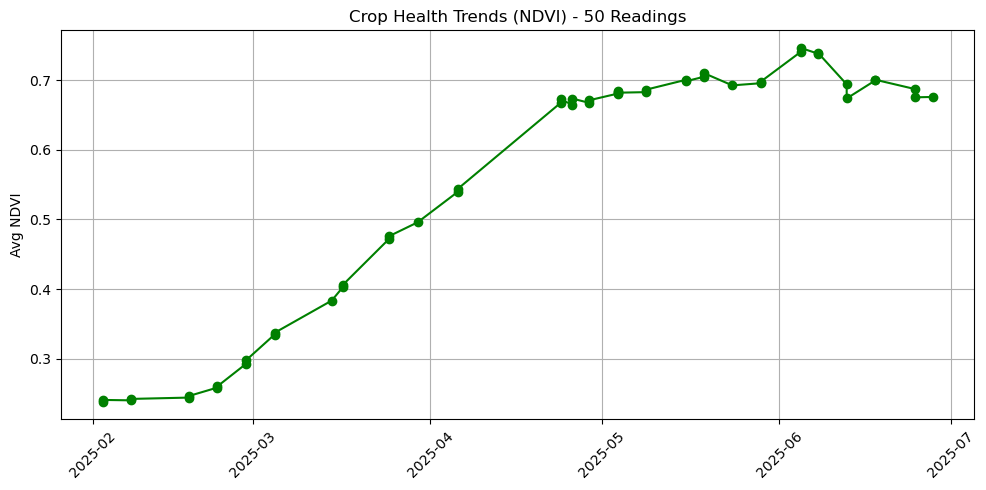

                      Date      NDVI
1  2025-02-02 18:16:27.618  0.238401
0  2025-02-02 18:16:31.594  0.240803
3  2025-02-07 18:16:02.295  0.240185
2  2025-02-07 18:16:06.271  0.242264
5  2025-02-17 18:16:05.188  0.244159
4  2025-02-17 18:16:09.153  0.246356
7  2025-02-22 18:16:23.277  0.258538
6  2025-02-22 18:16:27.262  0.260252
9  2025-02-27 18:16:03.275  0.292520
8  2025-02-27 18:16:07.242  0.297594
11 2025-03-04 18:16:24.802  0.334636
10 2025-03-04 18:16:28.780  0.337157
12 2025-03-14 18:16:27.706  0.383525
14 2025-03-16 18:16:13.138  0.403365
13 2025-03-16 18:16:17.117  0.406513
16 2025-03-24 18:16:22.461  0.471957
15 2025-03-24 18:16:26.439  0.475913
17 2025-03-29 18:16:01.639  0.495860
19 2025-04-05 18:16:12.853  0.539499
18 2025-04-05 18:16:16.826  0.543755
21 2025-04-23 18:16:22.393  0.667462
20 2025-04-23 18:16:26.363  0.672707
23 2025-04-25 18:16:14.782  0.664795
22 2025-04-25 18:16:18.752  0.673724
25 2025-04-28 18:16:01.995  0.667523
24 2025-04-28 18:16:05.961  0.671253
2

Map(center=[29.42359638593737, -110.91867413802873], controls=(WidgetControl(options=['position', 'transparent…

In [7]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define ROI
roi = ee.Geometry.Polygon([
    [
        [-110.921699, 29.423876],
        [-110.916021, 29.424890],
        [-110.915645, 29.423317],
        [-110.921334, 29.422303],
        [-110.921699, 29.423876]
    ]
])

# 2. Cloud Mask
def mask_s2_clouds(image):
    qa = image.select('QA60')
    mask = qa.bitwiseAnd(1<<10).eq(0).And(qa.bitwiseAnd(1<<11).eq(0))
    return image.updateMask(mask).divide(10000).copyProperties(image, ['system:time_start'])

# 3. Get Data
start_date = '2025-01-20'
end_date = '2025-06-30'

dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate(start_date, end_date)
    .filterBounds(roi)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .map(mask_s2_clouds)
)

# 4. Calculate NDVI Mean (The Math)
def get_ndvi_mean(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    stats = ndvi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=10,
        maxPixels=1e9
    )
    # Important: We set the result on the image
    return image.set('NDVI_Mean', stats.get('NDVI'))

# Apply the math to create a NEW collection
time_series = dataset.map(get_ndvi_mean)

# 5. Extract Data (FIXED: Use 'time_series', not 'dataset')
print("Extracting data...")
data = time_series.reduceColumns(
    reducer=ee.Reducer.toList(2), 
    selectors=['system:time_start', 'NDVI_Mean']
).getInfo()['list']

# 6. Create DataFrame
df = pd.DataFrame(data, columns=['timestamp', 'NDVI'])
df = df.dropna()
df['Date'] = pd.to_datetime(df['timestamp'], unit='ms')
df = df.sort_values('Date')

# 7. Plot the Chart
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['NDVI'], marker='o', linestyle='-', color='green')
plt.title(f'Crop Health Trends (NDVI) - {len(df)} Readings')
plt.ylabel('Avg NDVI')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the numbers
print(df[['Date', 'NDVI']])

# 8. Render the Map (Restored)
m = geemap.Map(basemap="HYBRID")
m.centerObject(roi, 15)

# Visualizing just the LAST image in the series so you have something to look at
recent_image = dataset.sort('system:time_start', False).first()
ndvi_layer = recent_image.normalizedDifference(['B8', 'B4']).clip(roi)
ndviParams = {'min': 0, 'max': 0.8, 'palette': ['red', 'yellow', 'green']}

m.addLayer(roi, {'color': 'blue'}, 'Your Polygon')
m.addLayer(ndvi_layer, ndviParams, 'NDVI (Latest)')
m